In [52]:
'''
__author__ = 'Alex Cheng'
惩罚回归系数控制过拟合-岭回归（L2）
让系数变小，而不是将其中一些系数设定为0
alpha一系列值按照10的倍数递减，通过不同值来控制模型数量
'''
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import datasets,linear_model
from sklearn.metrics import roc_curve,auc,roc_auc_score
from math import sqrt

In [2]:
target_url = ("http://archive.ics.uci.edu/ml/machine-learning-databases/"
             "undocumented/connectionist-bench/sonar/sonar.all-data")
df = pd.read_csv(target_url,header=None,sep=",",prefix='V')
df.head()

,V0,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V51,V52,V53,V54,V55,V56,V57,V58,V59,V60
0,0.0200,0.0371,0.0428,0.0207,0.0954,0.0986,0.1539,0.1601,0.3109,0.2111,...,0.0027,0.0065,0.0159,0.0072,0.0167,0.0180,0.0084,0.0090,0.0032,R
1,0.0453,0.0523,0.0843,0.0689,0.1183,0.2583,0.2156,0.3481,0.3337,0.2872,...,0.0084,0.0089,0.0048,0.0094,0.0191,0.0140,0.0049,0.0052,0.0044,R
2,0.0262,0.0582,0.1099,0.1083,0.0974,0.2280,0.2431,0.3771,0.5598,0.6194,...,0.0232,0.0166,0.0095,0.0180,0.0244,0.0316,0.0164,0.0095,0.0078,R
3,0.0100,0.0171,0.0623,0.0205,0.0205,0.0368,0.1098,0.1276,0.0598,0.1264,...,0.0121,0.0036,0.0150,0.0085,0.0073,0.0050,0.0044,0.0040,0.0117,R
4,0.0762,0.0666,0.0481,0.0394,0.0590,0.0649,0.1209,0.2467,0.3564,0.4459,...,0.0031,0.0054,0.0105,0.0110,0.0015,0.0072,0.0048,0.0107,0.0094,R


In [5]:
xList  = np.array(df.iloc[:,:-1]) # 属性数组
labels = []
names = df.columns
print(df.iloc[:,-1].value_counts()) # M:111, R:97

 # 二分类值转换为实数
for label in df.iloc[:,-1]:
    if(label == 'M'):
        labels.append(1.0)
    else:
        labels.append(0.0)


M    111
R     97
Name: V60, dtype: int64


In [8]:
# 正则化columns in x and labels
nrows = len(xList)
ncols = len(xList[0])

# 计算means and variance
xMeans = []
xSD = []
for i in range(ncols):
    col = [xList[j][i] for j in range(nrows)]
    mean = sum(col)/nrows
    xMeans.append(mean)
    colDiff = sum((col - mean) **2)
    
    colDiff2 = [(xList[j][i] - mean) for j in range(nrows) ]
    sumSq = sum([colDiff2[i]  * colDiff2[i] for i in range(nrows)])
    stdDev2 = sqrt(sumSq/nrows)
    
    stdDev = sqrt(colDiff/nrows)
    xSD.append(stdDev)
#print(xMeans,'\n',xSD)
#print(stdDev == stdDev2) # broadcast广播变量的方式，发现结果一样


# 正则化xList
xNorm = []
for i in range(nrows):
    #rowNorm = ([xList[i] - xMeans]) / xSD  #列表不支持
    rowNorm = [(xList[i][j] - xMeans[j]) / xSD[j] for j in range(ncols)]
    xNorm.append(rowNorm)

# 正则化 labels
meanLable = sum(labels)/ nrows
sdLabel = sqrt(sum([ (labels[i] - meanLable) * (labels[i] - meanLable) for i in range(nrows)]) / nrows)
labelNorm = [ (labels[i] - meanLable) / sdLabel for i in range(nrows) ]

In [68]:
# 交叉验证给出稳定的性能估计
# number of cross-validation folds
nxval = 10
for ixval in range(nxval): # 交叉验证
    # Define test and traing index sets
    idxTest =  [i for i in range(nrows) if i % nxval == ixval]
    idxTrain = [i for i in range(nrows) if i % nxval != ixval]
    #idxTest =  [i for i in range(nrows) if i % nxval ==0]
    #idxTrain = [i for i in range(nrows) if i % nxval !=0]

    # 定义测试和训练的属性和列表
    xTrain = [xNorm[r] for r in idxTrain]
    xTest  = [xNorm[r] for r in idxTest]
    yTrain = [labelNorm[r] for r in idxTrain]
    yTest  = [labelNorm[r] for r in idxTest] # 列向量
    
    # ElasticNet， 已经normlized，fit_intercept为False
    # coefs.shape = (60,100), 60个栏位，每组数据100次alpha尝试
    alphas,coefs,_ = linear_model.enet_path(xTrain,yTrain,l1_ration=0.8,
                                           fit_intercept=False,return_models=False)
    
    # 应用coefs测试数据产生预知和累计
    if ixval == 0:
        pred = np.dot(xTest,coefs) # 测试集预知，注意：每一次的测试集个数可能不一样
        yOut = yTest
    else:
        yTemp = np.array(yOut) 
        yOut = np.concatenate((yTemp,yTest),axis=0) # 垂直方向叠加起来，
        
        predTemp = np.array(pred)
        pred = np.concatenate((predTemp, np.dot(xTest,coefs)),axis=0) #（208,100）
    
    print(pred.shape)# （rows, 100）


# 计算错误
misClassRate = []
_,nPred = pred.shape # 列方向是默认100次alpha迭代的预测
for iPred in range(1,nPred): # 为什么从1开始？因为第0列的预测全部为0，不准没有参考价值
    predList = list(pred[:,iPred])
    errCnt = 0.0
    for irow in range(nrows):
        if (predList[irow] < 0.0) and (yOut[irow] >= 0.0):
            errCnt += 1.0
        elif (predList[irow] >= 0.0) and (yOut[irow] < 0.0):
            errCnt += 1.0
    misClassRate.append(errCnt/nrows)
        


(21, 100)
(42, 100)
(63, 100)
(84, 100)
(105, 100)
(126, 100)
(147, 100)
(168, 100)
(188, 100)
(208, 100)


In [74]:
alphas.shape,coefs.shape

((100,), (60, 100))

Min Error index of alpha 47


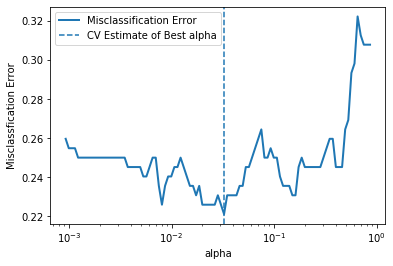

In [107]:
# 找到最小点绘图
minError = min(misClassRate)
idxMin = misClassRate.index(minError)
plotAlphas = list(alphas[1:len(alphas)])
print('Min Error index of alpha',idxMin)

# 分类错误与alpha
plt.figure()
plt.plot(plotAlphas,misClassRate,label='Misclassification Error',linewidth=2)
plt.axvline(plotAlphas[idxMin],linestyle='--',label='CV Estimate of Best alpha') # 最小值
plt.legend()
plt.semilogx()
ax = plt.gca()
ax.invert_xaxis()
plt.xlabel('alpha')
plt.ylabel('Misclassfication Error')
plt.axis('tight')
plt.show()

Max AUC of the index of alpha 49


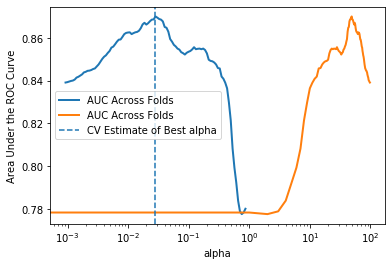

In [108]:
# 计算AUC     # pred(60,100),
idxPos = [i for i in range(nrows) if yOut[i] > 0.0] # 为什么是大于0？
yOutBin = [0] * nrows
for i in idxPos: yOutBin[i] = 1

auc = []
for iPred in range(1,nPred):
    predList = list(pred[:,iPred])
    aucCalc = roc_auc_score(yOutBin,predList)
    auc.append(aucCalc)
maxAUC = max(auc)
idxMax = auc.index(maxAUC)
print('Max AUC of the index of alpha',idxMax)

# AUC 面积和alpha
plt.figure()
plt.plot(plotAlphas,auc,auc, label='AUC Across Folds', linewidth=2)
plt.axvline(plotAlphas[idxMax],linestyle='--',label='CV Estimate of Best alpha')
plt.legend()
plt.semilogx()
ax = plt.gca()
ax.invert_xaxis()
plt.xlabel('alpha')
plt.ylabel('Area Under the ROC Curve')
plt.axis('tight')
plt.show()

<function matplotlib.pyplot.show(*args, **kw)>

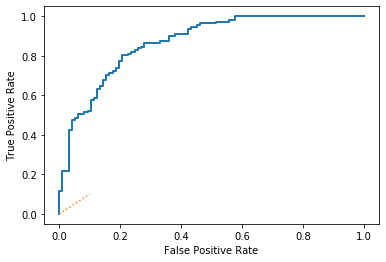

In [79]:
# ROC曲线在最大AUC时
fpr,tpr,thresh = roc_curve(yOutBin, list(pred[:,idxMax]))
ctClass = [i*0.01 for i in range(11)]
plt.plot(fpr,tpr,linewidth=2)
plt.plot(ctClass, ctClass, linestyle=':')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show


In [103]:
print('Best value of Misclassification Error= ', misClassRate[idxMin])
print('Beat alpha for Misclassification Error=', plotAlphas[idxMin])
print('')
print('Best value for AUC = ', auc[idxMax])
print('Best alpha for AUC = ', plotAlphas[idxMax])

print('')
print('Confusion Matrices for Different Threshold Values')

# 沿着ROC曲线挑取一些点
P = len(idxPos) # 取值为正
N = nrows - P

# ROC点
TP = tpr[16] * P
FN = P - TP
FP = fpr[16] * N
TN = N - FP
print('\nThreshold Vlaue=',thresh[16])
print('TP= ',TP, 'FN= ',FN)
print('FP= ',FP, 'TN= ',TN)

# ROC点
TP = tpr[52] * P
FN = P - TP
FP = fpr[52] * N
TN = N - FP
print('\nThreshold Vlaue=',thresh[52])
print('TP= ',TP, 'FN= ',FN)
print('FP= ',FP, 'TN= ',TN)

# tpr, fpr，threshold都是72长度，看看最小和最大阈值的confusion matrix
print('----------------------------')
TP = tpr[0] * P
FN = P - TP
FP = fpr[0] * N
TN = N - FP
print('\nThreshold Vlaue=',thresh[0])
print('TP= ',TP, 'FN= ',FN)
print('FP= ',FP, 'TN= ',TN)


TP = tpr[71] * P
FN = P - TP
FP = fpr[71] * N
TN = N - FP
print('\nThreshold Vlaue=',thresh[71])
print('TP= ',TP, 'FN= ',FN)
print('FP= ',FP, 'TN= ',TN)


Best value of Misclassification Error=  0.22115384615384615
Beat alpha for Misclassification Error= 0.032535813742947985

Best value for AUC =  0.8700659422308907
Best alpha for AUC =  0.028297991552286985

Confusion Matrices for Different Threshold Values

Threshold Vlaue= 0.2635334611160908
TP=  58.0 FN=  53.0
FP=  9.0 TN=  88.0

Threshold Vlaue= -0.26557472044035657
TP=  97.0 FN=  14.0
FP=  32.0 TN=  65.0
----------------------------

Threshold Vlaue= 3.740391161773192
TP=  0.0 FN=  111.0
FP=  0.0 TN=  97.0

Threshold Vlaue= -1.6395484709038615
TP=  111.0 FN=  0.0
FP=  97.0 TN=  0.0


array([0.        , 0.00900901, 0.11711712, 0.11711712, 0.21621622,
       0.21621622, 0.42342342, 0.42342342, 0.47747748, 0.47747748,
       0.48648649, 0.48648649, 0.5045045 , 0.5045045 , 0.51351351,
       0.51351351, 0.52252252, 0.52252252, 0.57657658, 0.57657658,
       0.58558559, 0.58558559, 0.63063063, 0.63063063, 0.64864865,
       0.64864865, 0.67567568, 0.67567568, 0.7027027 , 0.7027027 ,
       0.71171171, 0.71171171, 0.72072072, 0.72072072, 0.73873874,
       0.73873874, 0.77477477, 0.77477477, 0.8018018 , 0.8018018 ,
       0.81081081, 0.81081081, 0.81981982, 0.81981982, 0.82882883,
       0.82882883, 0.83783784, 0.83783784, 0.84684685, 0.84684685,
       0.86486486, 0.86486486, 0.87387387, 0.87387387, 0.9009009 ,
       0.9009009 , 0.90990991, 0.90990991, 0.93693694, 0.93693694,
       0.94594595, 0.94594595, 0.95495495, 0.95495495, 0.96396396,
       0.96396396, 0.97297297, 0.97297297, 0.98198198, 0.98198198,
       1.        , 1.        ])

In [81]:
fpr.shape

(72,)

In [84]:
df.shape

(208, 61)

In [99]:
len(idxPos)

111